In this notebook, we will do time series forecasting on the Etth2 dataset.

The dataset contains data from two electricity transformers collected for two years at an hourly rate. The goal is to predict oil temperature. Here, we are predicting the next 36 h = 1.5 d (=prediction_length) given a history of 72 h = 3 d (=context_length).

In [1]:
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.layers import (
    Dense, LSTM, Input, RepeatVector, TimeDistributed)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import logging
tf.get_logger().setLevel(logging.ERROR)
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)
pd.set_option("display.precision", 2)

url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"

df = pd.read_csv(url)

print("Head of dataframe:")
print(df.head())

features = {"date": "Date",
            "HUFL": "High UseFul Load", 
            "HULL": "High UseLess Load",
            "MUFL": "Middle UseFul Load",
            "MULL": "Middle UseLess Load",
            "LUFL": "Low UseFul Load",
            "LULL": "Low UseLess Load", 
            "OT": "Oil Temperature"}

print("\nDescription of features:")
_ = [print(x, "=", features[x]) for x in df.columns]

Head of dataframe:
                  date   HUFL   HULL   MUFL  MULL  LUFL  LULL     OT
0  2016-07-01 00:00:00  41.13  12.48  36.54  9.35  4.42  1.31  38.66
1  2016-07-01 01:00:00  37.53  10.14  33.94  7.53  4.43  1.22  37.12
2  2016-07-01 02:00:00  37.95  11.31  35.33  9.01  2.10  0.00  36.47
3  2016-07-01 03:00:00  38.95  11.90  35.54  9.44  3.38  1.22  33.61
4  2016-07-01 04:00:00  38.11  11.48  35.41  9.62  2.04  0.00  31.85

Description of features:
date = Date
HUFL = High UseFul Load
HULL = High UseLess Load
MUFL = Middle UseFul Load
MULL = Middle UseLess Load
LUFL = Low UseFul Load
LULL = Low UseLess Load
OT = Oil Temperature


Let' visualize the data:

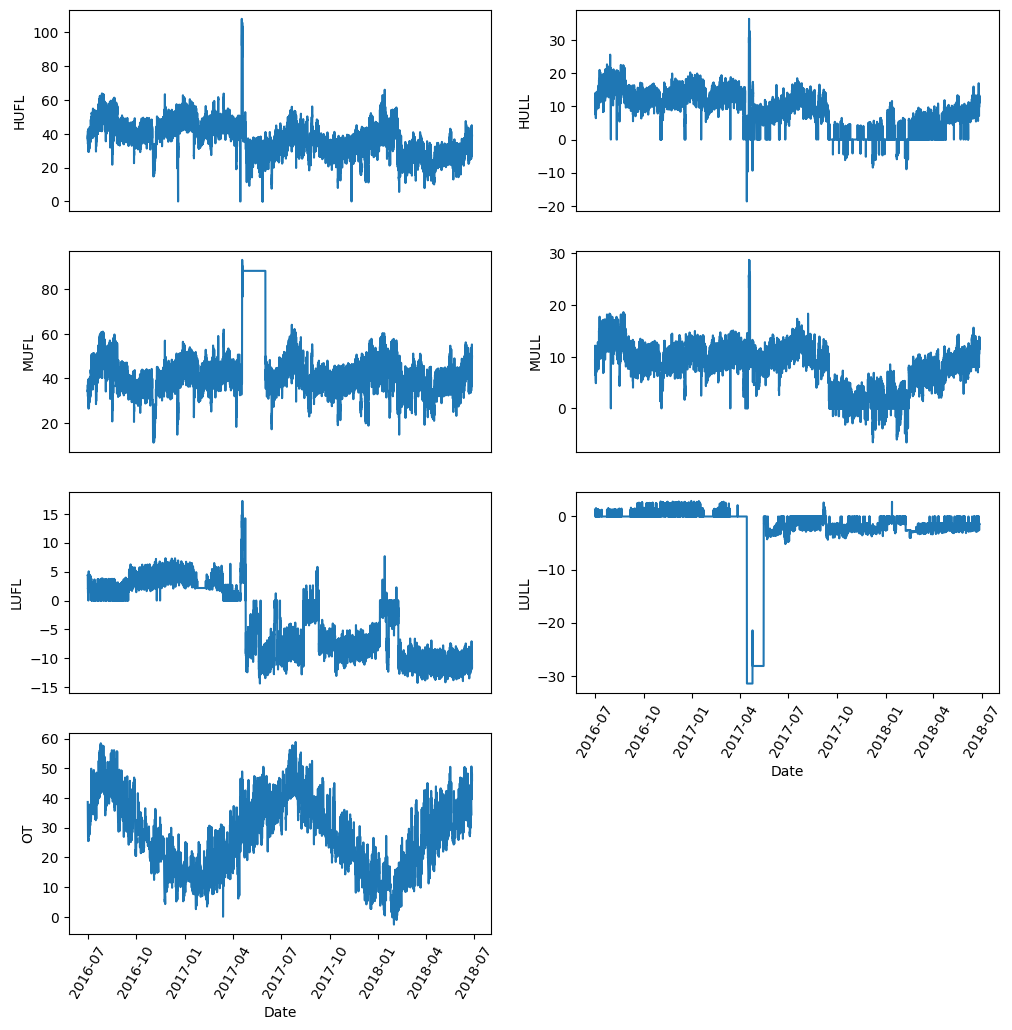

In [2]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")

fig, ax = plt.subplots(4, 2, figsize=(12, 12))
for idx, feat in enumerate(list(features.keys())[1:]):
    col = math.floor(idx / 2)
    row = idx % 2  
    ax[col, row].plot(df["date"], df[feat])
    ax[col, row].set_ylabel(feat)
    if idx >= len(list(features.keys())[1:]) - 2:
        ax[col, row].set_xlabel("Date")
        ax[col, row].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax[col, row].tick_params(axis="x", labelrotation=60)
    else:
        ax[col, row].get_xaxis().set_visible(False)
fig.delaxes(ax[3,1])
plt.show()

A clear annual pattern can be observed for the oil temperature  feature. But is there additional periodicity in the data? Let's have a look:

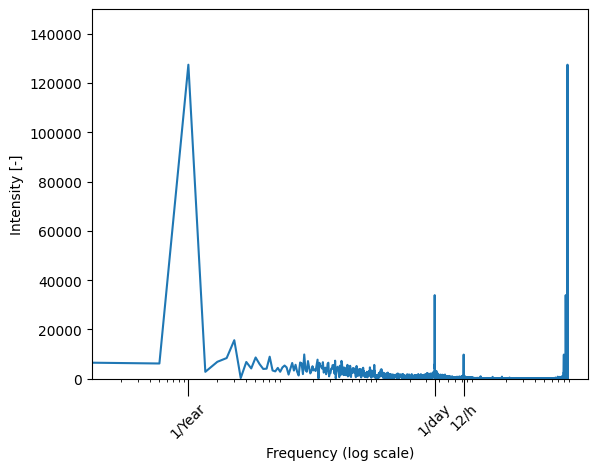

In [3]:
fft = np.fft.fft(df["OT"].to_numpy())

f_per_dataset = np.arange(0, len(fft))
f_per_year = len(df["OT"]) / (24 * 365)

fig, ax = plt.subplots()
ax.plot(f_per_dataset / f_per_year, np.abs(fft))
ax.set_xscale("log")
ax.set_ylim(0, 15e4)
ax.set_xlim([0.1, max(plt.xlim())])
ax.set_xticks([1, 365, 365*2])
ax.tick_params(axis="x", length=12)
ax.set_xticklabels(labels=["1/Year", "1/day", "12/h"], rotation=45)
ax.set_xlabel("Frequency (log scale)")
ax.set_ylabel("Intensity [-]")
plt.show()

We will use cyclical encoding to encode "day of the year" and also "hour of the day" information:

In [4]:
df["sin_d"] = df["date"].map(
    lambda x: np.sin((2 * np.pi * (x.timetuple().tm_hour)) / 24))       
df["cos_d"] = df["date"].map(
    lambda x: np.cos((2 * np.pi * (x.timetuple().tm_hour)) / 24))

df["sin_y"] = df["date"].map(
    lambda x: np.sin(
        (2 * np.pi * (x.timetuple().tm_yday + 
                      x.timetuple().tm_hour / 24)) / 365.25))
df["cos_y"] = df["date"].map(
    lambda x: np.cos((2 * np.pi * (x.timetuple().tm_yday + 
                                   x.timetuple().tm_hour / 24)) / 365.25))

df = df.drop(columns="date")

Now, let's create time series from the dataframe for training. We will use what is known as "non-anchored walk forward optimization" or "rolling window" for the creation of time series by the TimeSeriesPreprocessor class:

In [5]:
class MinMaxScaler:
    def fit(self, X, col_idxs):
        self.col_idxs = col_idxs
        self.mins = np.array([np.min(X[:, :, i]) for i in col_idxs])
        self.maxs = np.array([np.max(X[:, :, i]) for i in col_idxs])

    def transform(self, X):
        X_copy = copy.deepcopy(X).astype(np.float32)
        for i in self.col_idxs:
            X_copy[:, :, i] = ((X[:, :, i] - self.mins[i]) / 
                          (self.maxs[i] - self.mins[i]))
        return X_copy
    
    def inverse_transform(self, X_scaled):
        X = np.zeros_like(X_scaled)
        for i in self.col_idxs:
            X[:, :, i] = (X_scaled[:, :, i] * 
                          (self.maxs[i] - self.mins[i]) + self.mins[i])
        return X
    
    
class TimeSeriesPreprocessor:
    def __init__(self):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        
    def split_df(self, df, train_ratio, val_ratio):
        train_max_idx = int(len(df) * train_ratio)
        val_max_idx = train_max_idx + int(len(df) * val_ratio)
        
        df_train = df[0:train_max_idx]
        df_val = df[train_max_idx:val_max_idx]
        df_test = df[val_max_idx:]
        return df_train, df_val, df_test
    
    def roll_ts(self, df, pred_length, context_length, delay, roll_ts, 
                x_col_idxs, y_col_idxs):
        window_length = context_length + pred_length + delay
        
        if roll_ts != 0:
            window_length = roll_ts

        idx_x_start = list(range(0, len(df), window_length))
        idx_x_end = list(range(context_length, len(df), window_length))
        idx_x = [list(range(x[0], x[1])) for x in 
                 list(zip(idx_x_start, idx_x_end))]
        
        idx_y_start = [x+delay for x in idx_x_end]
        idx_y_end = [x+pred_length for x in idx_y_start]
        
        idx_to_remove = [idx for (idx, x) in enumerate(idx_y_end) 
                         if x > len(df)]
        if len(idx_to_remove) > 0:
            idx_x = idx_x[:idx_to_remove[0]]
            idx_y_start = idx_y_start[:idx_to_remove[0]]
            idx_y_end = idx_y_end[:idx_to_remove[0]]
        idx_y = [list(range(x[0], x[1])) for x in 
                 list(zip(idx_y_start, idx_y_end))]

        x = df.iloc[:, x_col_idxs].to_numpy()[idx_x]
        y = df.iloc[:, y_col_idxs].to_numpy()[idx_y]
        
        if len(x.shape) == 2:
            x = np.expand_dims(x, 2)
        if len(y.shape) == 2:
            y = np.expand_dims(y, 2)
        return x, y
    
    def min_max_scale(self, x, y, x_col_to_scale_idxs, y_col_to_scale_idxs, 
                      train_data):
        if train_data:
            self.scaler_x.fit(x, x_col_to_scale_idxs)
            self.scaler_y.fit(y, y_col_to_scale_idxs)
        x_scaled = self.scaler_x.transform(x)
        y_scaled = self.scaler_y.transform(y)
        return x_scaled, y_scaled
        
    def create_dataset(self, x, y, batch_size, shuffle):
        if shuffle:
            ds = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(
                x.shape[0]).batch(batch_size)
        else:
            ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        return ds
        
    def preprocess(
            self, df, train_ratio, val_ratio, pred_length, context_length, 
            delay, roll_ts_train, roll_ts_val, x_col_idxs, y_col_idxs, 
            x_col_to_scale_idxs, y_col_to_scale_idxs, batch_size):
        
        df_train, df_val, df_test = self.split_df(
            df, train_ratio, val_ratio)
        
        x_train, y_train = self.roll_ts(
            df_train, pred_length, context_length, delay, roll_ts_train, 
            x_col_idxs, y_col_idxs)
        x_val, y_val = self.roll_ts(
            df_val, pred_length, context_length, delay, roll_ts_val, 
            x_col_idxs, y_col_idxs)
        x_test, y_test = self.roll_ts(
            df_test, pred_length, context_length, delay, roll_ts_val, 
            x_col_idxs, y_col_idxs)

        x_train, y_train = self.min_max_scale(
            x_train, y_train, x_col_to_scale_idxs, y_col_to_scale_idxs, 
            train_data=True)
        x_val, y_val = self.min_max_scale(
            x_val, y_val, x_col_to_scale_idxs, y_col_to_scale_idxs, 
            train_data=False)
        x_test, y_test = self.min_max_scale(
            x_test, y_test, x_col_to_scale_idxs, y_col_to_scale_idxs, 
            train_data=False)
        
        ds_train = self.create_dataset(
            x_train, y_train, batch_size, shuffle=True)
        ds_val = self.create_dataset(x_val, y_val, batch_size, shuffle=False)
        ds_test = self.create_dataset(
            x_test, y_test, batch_size, shuffle=False)
        return ds_train, ds_val, ds_test

To get an intuition how the TimeSeriesPreprocessor class operates, you can experiment with dummy data:

In [6]:
df_dummy = pd.DataFrame.from_dict({"col_1": list(range(0, 15))})

x0_dummy, y0_dummy = TimeSeriesPreprocessor().roll_ts(
    df=df_dummy, pred_length=2, context_length=3, delay=0, roll_ts=0, 
    x_col_idxs=0, y_col_idxs=0)
print("Test1:")
print(x0_dummy[:, :, 0])
print(y0_dummy[:, :, 0])

x1_dummy, y1_dummy = TimeSeriesPreprocessor().roll_ts(
    df=df_dummy, pred_length=2, context_length=3, delay=1, roll_ts=2, 
    x_col_idxs=0, y_col_idxs=0)

print("\nTest2:")
print(x1_dummy[:, :, 0])
print(y1_dummy[:, :, 0])

Test1:
[[ 0  1  2]
 [ 5  6  7]
 [10 11 12]]
[[ 3  4]
 [ 8  9]
 [13 14]]

Test2:
[[ 0  1  2]
 [ 2  3  4]
 [ 4  5  6]
 [ 6  7  8]
 [ 8  9 10]]
[[ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]]


Now we will preprocess our actual data:

In [7]:
pred_length = 36
context_length = 72

x_col_idxs = list(range(len(df.columns)))
y_col_idxs = [df.columns.get_loc(x) for x in ["OT"]]
x_col_to_scale_idxs = [df.columns.get_loc(x) for x in 
                       ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]]
y_col_to_scale_idxs = [idx for idx, x in enumerate(["OT"])]

preprocessor = TimeSeriesPreprocessor()
ds_train, ds_val, ds_test = preprocessor.preprocess(
    df=df, train_ratio=0.6, val_ratio=0.2, pred_length=pred_length, 
    context_length=context_length, delay=0, roll_ts_train=6, roll_ts_val=6, 
    x_col_idxs=x_col_idxs, y_col_idxs=y_col_idxs, 
    x_col_to_scale_idxs=x_col_to_scale_idxs, 
    y_col_to_scale_idxs=y_col_to_scale_idxs, batch_size=64)

And define a simple LSTM model:

In [8]:
input_shape = (context_length, len(x_col_idxs))
output_shape = (pred_length, len(y_col_idxs))
hidden_units = 64

class LSTMModel(Model):
    def __init__(self, units, input_shape, output_shape):
        super().__init__()
        self.layer0 = LSTM(units, return_sequences=True)
        self.layer1 = LSTM(units)
        self.layer2 = RepeatVector(output_shape[0])
        self.layer3 = LSTM(units, return_sequences=True)
        self.layer4 = TimeDistributed(Dense(units*2, activation="relu"))
        self.layer5 = TimeDistributed(
            Dense(output_shape[1], activation="linear"))
        
    def call(self, inputs):
        x = inputs
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

    def build_graph(self, input_shape):
        inputs1 = Input(shape=input_shape)
        return Model(inputs=[inputs1], 
                     outputs=self.call([inputs1]))

model1 = LSTMModel(hidden_units, input_shape, output_shape)
model1.build_graph(input_shape=input_shape).summary(line_length=100)

Model: "model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_1 (InputLayer)                        [(None, 72, 11)]                        0              
                                                                                                    
 lstm (LSTM)                                 (None, 72, 64)                          19456          
                                                                                                    
 lstm_1 (LSTM)                               (None, 64)                              33024          
                                                                                                    
 repeat_vector (RepeatVector)                (None, 36, 64)                          0              
                                                                            

We will use a custom made learning rate scheduler that either reduces learning rate on a plateau or restarts it:

In [9]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau(callbacks.Callback):
    def __init__ (self, model, lr_initial, lr_decay, patience, factor_reduce, 
                  factor_restart, max_lr_restart, restart_after_x_reductions, 
                  increment_restart_after_x_reductions, min_loss_improvement):
        super(MultiplicativeDecayWithReduceOrRestartOnPlateau, self).__init__()
        self.model = model
        self.lr_initial = lr_initial
        self.lr_decay = lr_decay
        self.patience = patience
        self.factor_reduce = factor_reduce
        self.factor_restart = factor_restart
        self.max_lr_restart = max_lr_restart
        self.restart_after_x_reductions = restart_after_x_reductions
        self.increment_restart_after_x_reductions = \
            increment_restart_after_x_reductions
        self.min_loss_improvement = min_loss_improvement
        
        self.val_loss_best = np.Inf
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.just_restarted = False

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            tf.keras.backend.set_value(
                self.model.optimizer.lr, self.lr_initial)

    def on_loss_improvement(self, cur_val_loss):
        self.val_loss_best = cur_val_loss
        self.plateau_epochs = 0
        
    def on_loss_deterioration(self):
        self.plateau_epochs += 1
    
    def on_plateau(self, lr):
        if self.reductions_counter >= self.restart_after_x_reductions:
            lr_new = self.restart_lr()
        else:
            lr_new = self.step_reduce_lr(lr)
        return lr_new

    def multiplicative_decay_lr(self, lr):
        return lr * self.lr_decay

    def step_reduce_lr(self, lr):
        lr_new = lr * self.factor_reduce
        self.plateau_epochs = 0
        self.reductions_counter += 1
        return lr_new

    def restart_lr(self):
        self.lr_initial *= self.factor_restart
        lr_new = self.lr_initial
        if lr_new > self.max_lr_restart:
            lr_new = self.max_lr_restart
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.restart_after_x_reductions += \
            self.increment_restart_after_x_reductions
        self.just_restarted = True
        return lr_new

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        cur_val_loss = logs.get("val_loss")
        
        if 1 - (cur_val_loss / self.val_loss_best) > self.min_loss_improvement: 
            self.on_loss_improvement(cur_val_loss)
        else:
            self.on_loss_deterioration()
        lr_new = self.multiplicative_decay_lr(lr)
        
        if self.just_restarted:
            self.val_loss_best = cur_val_loss
            self.just_restarted = False
        
        if self.plateau_epochs >= self.patience:
            lr_new = self.on_plateau(lr)
            
        tf.keras.backend.set_value(self.model.optimizer.lr, lr_new)
        if logs is None or "learning_rate" in logs:
            return 
        logs["learning_rate"] = lr

Let's train:

Epoch 1/200
27/27 [==============================] - 13s 238ms/step - loss: 0.2234 - val_loss: 0.1069 - learning_rate: 3.0000e-04
Epoch 2/200
27/27 [==============================] - 4s 159ms/step - loss: 0.0966 - val_loss: 0.0894 - learning_rate: 2.8800e-04
Epoch 3/200
27/27 [==============================] - 4s 152ms/step - loss: 0.0864 - val_loss: 0.0828 - learning_rate: 2.7648e-04
Epoch 4/200
27/27 [==============================] - 4s 142ms/step - loss: 0.0807 - val_loss: 0.0782 - learning_rate: 2.6542e-04
Epoch 5/200
27/27 [==============================] - 4s 144ms/step - loss: 0.0783 - val_loss: 0.0740 - learning_rate: 2.5480e-04
Epoch 6/200
27/27 [==============================] - 4s 132ms/step - loss: 0.0764 - val_loss: 0.0748 - learning_rate: 2.4461e-04
Epoch 7/200
27/27 [==============================] - 4s 137ms/step - loss: 0.0739 - val_loss: 0.0701 - learning_rate: 2.3483e-04
Epoch 8/200
27/27 [==============================] - 4s 136ms/step - loss: 0.0731 - val_loss: 0.

27/27 [==============================] - 3s 127ms/step - loss: 0.0450 - val_loss: 0.0577 - learning_rate: 5.1940e-05
Epoch 65/200
27/27 [==============================] - 3s 127ms/step - loss: 0.0449 - val_loss: 0.0580 - learning_rate: 4.9862e-05
Epoch 66/200
27/27 [==============================] - 4s 137ms/step - loss: 0.0448 - val_loss: 0.0581 - learning_rate: 4.7868e-05
Epoch 67/200
27/27 [==============================] - 3s 129ms/step - loss: 0.0448 - val_loss: 0.0575 - learning_rate: 4.5953e-05
Epoch 68/200
27/27 [==============================] - 3s 127ms/step - loss: 0.0447 - val_loss: 0.0577 - learning_rate: 1.1488e-05
Epoch 69/200
27/27 [==============================] - 3s 129ms/step - loss: 0.0446 - val_loss: 0.0583 - learning_rate: 1.1029e-05
Epoch 70/200
27/27 [==============================] - 4s 133ms/step - loss: 0.0446 - val_loss: 0.0579 - learning_rate: 1.0588e-05
Epoch 71/200
27/27 [==============================] - 4s 135ms/step - loss: 0.0446 - val_loss: 0.0580 -

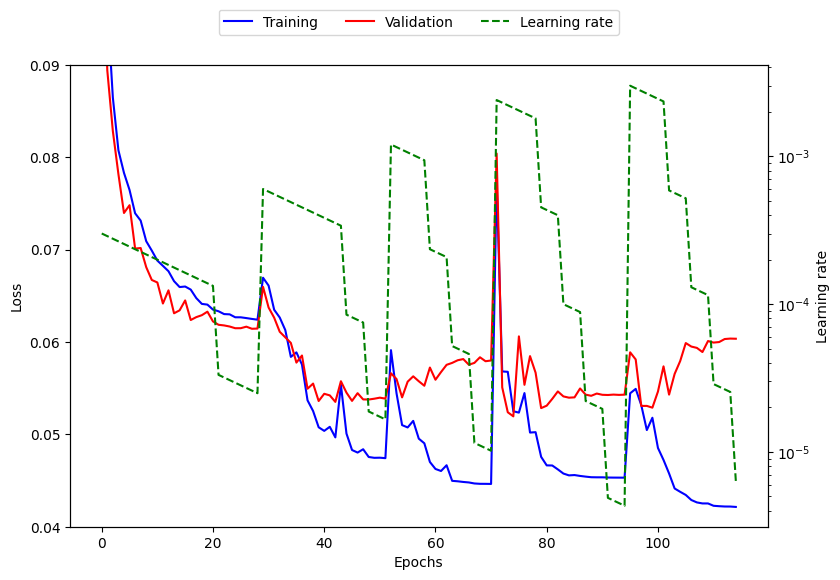

In [10]:
model1.compile(optimizer=Adam(learning_rate=1e-3), loss="mae")

cb1 = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=40)               
cb2 = MultiplicativeDecayWithReduceOrRestartOnPlateau(
    model=model1, lr_initial=3e-4, lr_decay=0.96, patience=4, factor_reduce=0.25, 
    factor_restart=2, max_lr_restart=3e-3, restart_after_x_reductions=1, 
    increment_restart_after_x_reductions=1, min_loss_improvement=0.005)

cb3 = callbacks.ModelCheckpoint(
    "./model1/", monitor="val_loss", save_best_only=True, 
    save_weights_only=True, verbose=0)


history = model1.fit(ds_train, epochs=200,  validation_data=ds_val,
                     verbose=1, callbacks=[cb1, cb2, cb3])


fig, ax_a = plt.subplots(figsize=(9, 6))
l1 = ax_a.plot(history.history["loss"], color="b", label="Training")
l2 = ax_a.plot(history.history["val_loss"], color="r", label="Validation")
ax_a.set_xlabel("Epochs")
ax_a.set_ylabel("Loss")
ax_a.set_ylim(0.04, 0.09)
ax_b = ax_a.twinx() 
l3 = ax_b.plot(history.history["learning_rate"], color="g", linestyle="dashed", 
                label="Learning rate")
ax_b.set_ylabel("Learning rate")
ax_b.set_yscale("log")
ax_a.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center", 
            bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=4)        
plt.show()

And see how the model predicts on the holdout test data:

The mean absolute error of the LSTM model without teacher forcing on the validation set is: 3.06.
The mean absolute error of the LSTM model without teacher forcing on the test set is: 3.68.


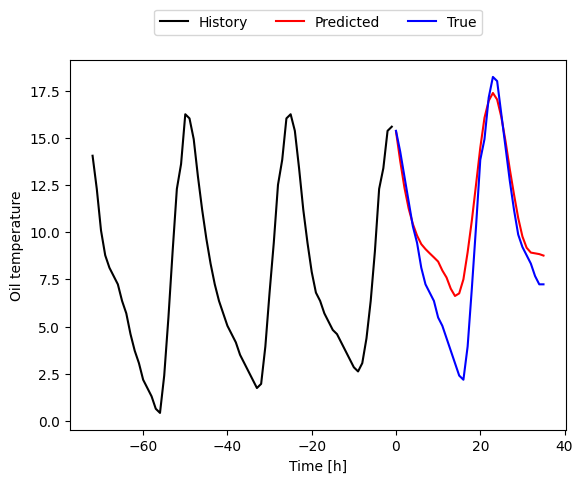

In [11]:
X_val = np.concatenate([x for x, y in ds_val], axis=0)
y_val = np.concatenate([y for x, y in ds_val], axis=0)
model1 = LSTMModel(hidden_units, input_shape, output_shape)
model1.load_weights("./model1/")

y_val_pred1 = model1.predict(ds_val)
X_val_rescaled = preprocessor.scaler_x.inverse_transform(X_val)
y_val_rescaled = preprocessor.scaler_y.inverse_transform(y_val)
y_val_pred1_rescaled = preprocessor.scaler_y.inverse_transform(y_val_pred1)

mae = MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
result0 = np.mean(mae(y_val_rescaled, y_val_pred1_rescaled).numpy())
print(f"""The mean absolute error of the LSTM model without teacher 
forcing on the validation set is: {result0:.2f}.""".replace("\n",""))


X_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)
y_test_pred1 = model1.predict(ds_test)
X_test_rescaled = preprocessor.scaler_x.inverse_transform(X_test)
y_test_rescaled = preprocessor.scaler_y.inverse_transform(y_test)
y_test_pred1_rescaled = preprocessor.scaler_y.inverse_transform(y_test_pred1)

result1 = np.mean(mae(y_test_rescaled, y_test_pred1_rescaled).numpy())
print(f"""The mean absolute error of the LSTM model without teacher 
forcing on the test set is: {result1:.2f}.""".replace("\n",""))

idx = 12
fig, ax = plt.subplots()
ax.plot(list(range(-context_length, 0)), 
    X_test_rescaled[idx, :, 6], color="k", label="History")
ax.plot(list(range(0, pred_length)), 
    y_test_pred1_rescaled[idx, :, 0], color="r", label="Predicted")
ax.plot(list(range(0, pred_length)), 
    y_test_rescaled[idx, :, 0], color="b", label="True")
ax.set_ylabel("Oil temperature")
ax.set_xlabel("Time [h]")
ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
plt.show()

To put above results into perspective, we will have look how a baseline model that simply repeats the mean value of the input data performs in comparison:

The mean absolute error on test set for a baseline, that simply repeats the mean of the history at every timestep of the prediction, is: 5.07.


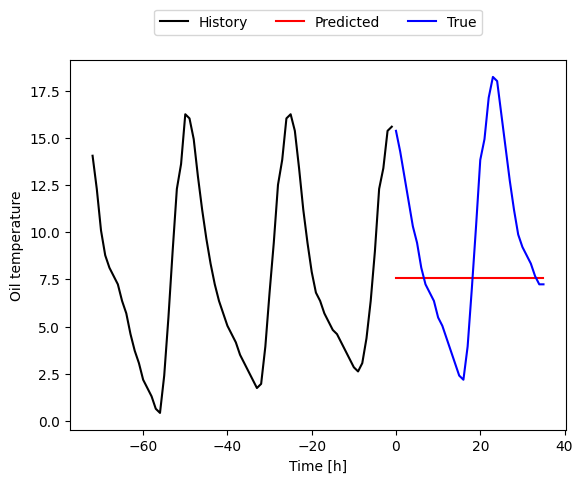

In [12]:
class BaselineMeanModel(Model):
    def __init__(self, target_col_idx, out_shape):
        super().__init__()
        self.target_col_idx = target_col_idx
        self.out_shape = out_shape
        
    def call(self, x):
        return tf.expand_dims(tf.repeat(tf.reshape(tf.math.reduce_mean(
            x[:, :, self.target_col_idx], axis=1), (-1, 1)), 
                                        self.out_shape[1], axis=1), 2)
    

model2 = BaselineMeanModel(target_col_idx=6, out_shape=y_test.shape)
model2.compile(optimizer=Adam(learning_rate=1e-3), loss="mae")

y_test_pred2 = model2.predict(X_test)
y_test_pred2_rescaled = preprocessor.scaler_y.inverse_transform(y_test_pred2)

result2 = np.mean(mae(y_test_rescaled, y_test_pred2_rescaled).numpy())
print(f"""The mean absolute error on test set for a baseline, that simply 
repeats the mean of the history at every timestep of the prediction, is: 
{result2:.2f}.""".replace("\n",""))

fig, ax = plt.subplots()
ax.plot(list(range(-context_length, 0)), 
    X_test_rescaled[idx, :, 6], color="k", label="History")
ax.plot(list(range(0, pred_length)), 
    y_test_pred2_rescaled[idx, :, 0], color="r", label="Predicted")
ax.plot(list(range(0, pred_length)), 
    y_test_rescaled[idx, :, 0], color="b", label="True")
ax.set_ylabel("Oil temperature")
ax.set_xlabel("Time [h]")
ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
plt.show()